In [9]:
import os
import pandas as pd
import re
from tqdm import tqdm

basic_info_df = pd.read_csv('data/parkings_info.csv')
basic_info_df['lat_long'] = list(zip(basic_info_df['latitude'], basic_info_df['longitude']))

In [10]:
from graph_utils import build_graph

target_park = '电影大厦'
target_area, adj_matrix, target_map, nks, kns = build_graph(basic_info_df, target_park)
target_park_basic_info = basic_info_df.loc[basic_info_df.parking_name == target_park].iloc[0]

In [11]:
from IPython.display import Image, display
from datetime import date, timedelta
import pandas as pd
import numpy as np

def build_area_seqs(target_area, start='2016-08-01', end='2017-01-01'):
    # 整合到一个文件中
    area_df = pd.DataFrame()
    for name in target_area.parking_name:
        file_name = 'data/seqs/'+name+'_seq.csv'
        file_df = pd.read_csv(file_name)
        file_df['parking'] = nks[name]
        cols = file_df.columns.tolist()
        cols = [cols[0], cols[2], cols[1]]
        file_df = file_df[cols]
        if len(area_df)>0:
            area_df = pd.concat([area_df, file_df])
        else:
            area_df = file_df

    out_bound_indexes = area_df[(area_df['date'] < start) | (area_df['date'] >= end)].index 
    area_df.drop(out_bound_indexes, inplace = True) 
    return area_df.pivot_table('occupy', ['date'], 'parking')

In [12]:
seqs_raw = build_area_seqs(target_area, start='2016-10-01', end='2016-11-01')
# normalization
seqs_normal = seqs_raw/seqs_raw.max()
adj = adj_matrix

In [13]:
import tensorflow as tf
from abc import ABC
from spektral.layers import GraphConv
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, GRU, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.datasets import mnist
from spektral.layers import GraphConv
from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian
l2_reg = 5e-4         # Regularization rate for l2

class Generator(tf.keras.Model, ABC):

    def __init__(self, seq=2976, N=11):
        super(Generator, self).__init__()
        self.dropout = Dropout(0.5)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(1,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=True)
        self.graph_conv_2 = GraphConv(N,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=True)
        self.dense128_1 = Dense(128, activation='relu')
        self.dense128_2 = Dense(128, activation='relu')
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(seq, activation='softmax')

    def call(self, seq, adj, training=True):
        g = tf.convert_to_tensor(normalized_laplacian(adj)) # 11*11
        s = tf.convert_to_tensor(seq) # 11*2976
        
        s = self.dropout(s)
        
        c = self.graph_conv_1([s, g])
        c = self.dropout(c)
        c = self.graph_conv_2([c,g])
        
        c = self.flatten(c)
        
        fc = self.dense128_1(c)                  
        fc = self.dropout(fc)
        fc = self.dense128_2(fc)                  
        fc = self.dropout(fc)

        fc = tf.expand_dims(fc, axis=0)
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)
        return self.final_dense(ro)

In [14]:
class Discriminator(tf.keras.Model, ABC):

    def __init__(self, seq=2976, N=11):
        super(Discriminator, self).__init__()
        self.dropout = Dropout(0.5)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(1,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=True)
        self.graph_conv_2 = GraphConv(N,
                               activation='elu',
                               kernel_regularizer=l2(l2_reg),
                               use_bias=True)
        self.dense128_1 = Dense(128, activation='relu')
        self.dense128_2 = Dense(128, activation='relu')
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(seq, activation='tanh')

    def call(self, seq, adj, training=True):
        g = tf.convert_to_tensor(normalized_laplacian(adj)) # 11*11
        s = tf.convert_to_tensor(seq) # 11*2976
        
        s = self.dropout(s)
        
        c = self.graph_conv_1([s, g])
        c = self.dropout(c)
        c = self.graph_conv_2([c,g])
        
        c = self.flatten(c)
        
        fc = self.dense128_1(c)                  
        fc = self.dropout(fc)
        fc = self.dense128_2(fc)                  
        fc = self.dropout(fc)

        fc = tf.expand_dims(fc, axis=0)
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)
        return self.final_dense(ro)

In [15]:
import os

from tensorflow.keras.optimizers import Adam
from image_utils import save_images, save_images_batch, sample_noise

import time
import tensorflow as tf
import numpy as np

batch_size = 96
save_interval = 5


class Train:
    def __init__(self, seqs, adj, epochs=1000, key=9):
        self.epochs = epochs
        self.gen_optimizer = Adam(0.00001)
        self.desc_optimizer = Adam(0.0002, 0.5)
        self.generator = Generator(seqs.shape[0], seqs.shape[1])
        self.discriminator = Discriminator(seqs.shape[0], seqs.shape[1])
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.seqs = seqs
        self.adj = adj
        self.seqs_replace = seqs.copy()
        max_parks = seqs_normal[key].max()
        self.seqs_replace[key] = np.random.normal(max_parks/2.0, max_parks/10.0, size=(seqs.shape[0]))
        self.key=key
        
    def __call__(self, save_path='saved'):
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        time_consumed_total = 0.
        for epoch in range(1, self.epochs + 1):
            start = time.time()
            total_gen_loss = 0
            total_disc_loss = 0
            
            gen_loss, disc_loss = self.train_step(self.seqs, self.adj)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss

            time_consumed = time.time() - start
            time_consumed_total += time_consumed
            time_consumed_agv = time_consumed_total / epoch
            self.epochs_last = self.epochs - epoch
            estimate_time_last = self.epochs_last * time_consumed_agv
            if epoch%1000==0:
                print('epoch {}/{} - gen_loss = {}, disc_loss = {}, elaps {}, estimated to finish: {}'
                      .format(epoch, self.epochs, # time.time() - start,
                              round(float(total_gen_loss),5),
                              round(float(total_disc_loss),5),
                              round(time_consumed_total,2),
                              round(estimate_time_last,2)))
            
    def train_step(self, seqs, adj, key=9):
        with tf.GradientTape(persistent=True) as tape:
            # add noise for target_park
            seqs_replace = seqs.copy()
            max_parks = seqs_normal[key].max()
            seqs_replace[key] = np.random.normal(max_parks/2.0, max_parks/10.0, size=(seqs.shape[0]))
            generated = self.generator(tf.transpose(seqs_replace), adj)
            # print('generated', generated.shape)
            real_output = self.discriminator(tf.transpose(seqs), adj) # 评价高
            # seqs_replace[key] = tf.transpose(generated)
            generated_output = self.discriminator(generated, adj) # 初始评价低

            loss_g = self.generator_loss(self.cross_entropy, generated_output)
            loss_d = self.discriminator_loss(self.cross_entropy, real_output, generated_output)

        grad_gen = tape.gradient(loss_g, self.generator.trainable_variables)
        grad_disc = tape.gradient(loss_d, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.desc_optimizer.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))

        return loss_g, loss_d
    
    def generate(self):
        return self.generator(tf.transpose(self.seqs_replace), self.adj)
    
    @staticmethod
    def discriminator_loss(loss_object, real_output, fake_output):
        """
        ...
        """
        real_loss = loss_object(tf.ones_like(real_output), real_output)
        fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @staticmethod
    def generator_loss(loss_object, fake_output):
        """
        ...
        """
        return loss_object(tf.ones_like(fake_output), fake_output)

In [20]:
train = Train(seqs_normal, adj, 50000)
train()

epoch 1000/50000 - gen_loss = 1.2722, disc_loss = 0.78471, elaps 68.85, estimated to finish: 3373.7
epoch 2000/50000 - gen_loss = 1.28638, disc_loss = 0.69767, elaps 133.09, estimated to finish: 3194.07
epoch 3000/50000 - gen_loss = 1.08196, disc_loss = 0.99688, elaps 196.49, estimated to finish: 3078.27
epoch 4000/50000 - gen_loss = 1.27931, disc_loss = 0.64202, elaps 260.19, estimated to finish: 2992.23
epoch 5000/50000 - gen_loss = 1.2997, disc_loss = 0.63201, elaps 323.42, estimated to finish: 2910.75
epoch 6000/50000 - gen_loss = 1.30788, disc_loss = 0.65934, elaps 386.89, estimated to finish: 2837.16
epoch 7000/50000 - gen_loss = 1.30479, disc_loss = 0.62974, elaps 450.19, estimated to finish: 2765.48
epoch 8000/50000 - gen_loss = 1.30978, disc_loss = 0.62782, elaps 513.52, estimated to finish: 2695.97
epoch 9000/50000 - gen_loss = 1.31129, disc_loss = 0.62724, elaps 576.95, estimated to finish: 2628.34
epoch 10000/50000 - gen_loss = 1.31243, disc_loss = 0.62683, elaps 641.28, es

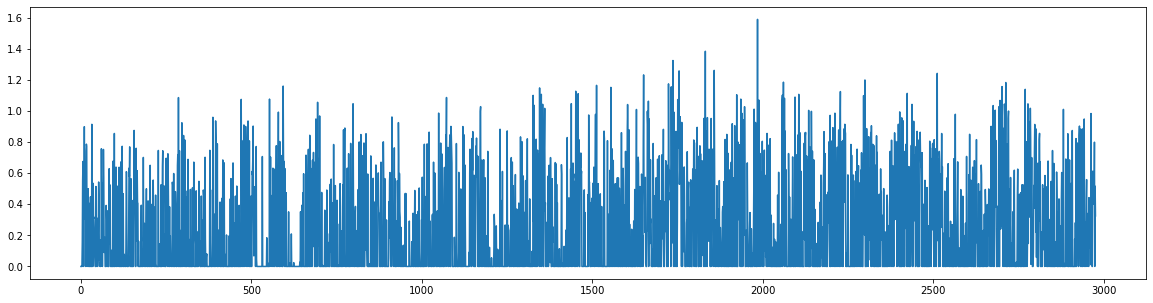

In [21]:
gen_data = train.generator(tf.transpose(train.seqs_replace), train.adj)
gen_df = pd.DataFrame(tf.transpose(gen_data).numpy())
# gen_df.plot(figsize=(20, 5))
gen_df[9].plot(figsize=(20, 5))

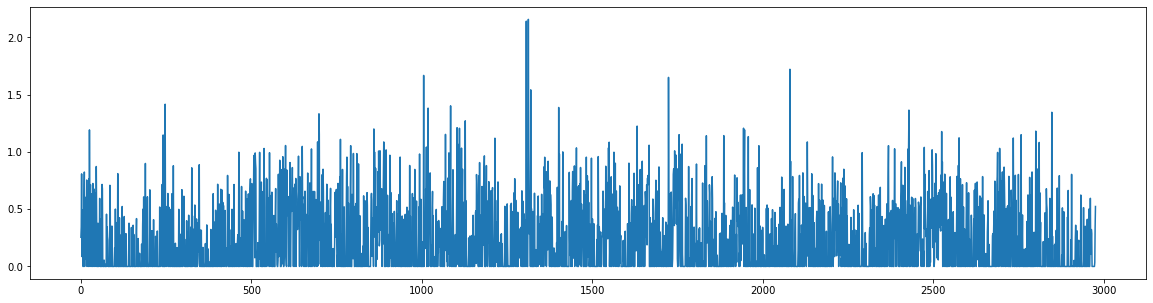

In [19]:
gen_df[9].plot(figsize=(20, 5))